# [RSNA Screening Mammography Breast Cancer Detection](https://www.kaggle.com/c/petfinder-pawpularity-score)
> Find breast cancers in screening mammograms

![](https://storage.googleapis.com/kaggle-competitions/kaggle/39272/logos/header.png?t=2022-11-28-17-29-35)

# Idea:
* In this notebook will generate **bounding box (bbox)** from **gradcam** images.
* BBoxes can be then used with Object Detection models for **Cancer Detection**
* **Wandb** is integrated hence we can use this notebook for visual analysis.
* **Image**, **Mask**, **GradCAM** & **BBox** is logged in **WandB**

# Notebooks
* Only Image:
    * ROI:
        * train: [RSNA-BCD: EfficientNet [TF][TPU-1VM][Train]](https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-train)
        * infer: [RSNA-BCD: EfficientNet [TF][TPU-1VM][Infer]](https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-infer)
    * NoROI + KerasCV: 
        * train: [RSNA-BCD: NoROI KerasCV [TF][Train]](https://www.kaggle.com/awsaf49/rsna-bcd-noroi-kerascv-tf-train/)
        * infer: [RSNA-BCD: NoROI KerasCV [TF][Infer]](https://www.kaggle.com/awsaf49/rsna-bcd-noroi-kerascv-tf-infer/)
* Dataset:
    * ROI:
        * [RSNA-BCD: ROI 1024x PNG Dataset](https://www.kaggle.com/datasets/awsaf49/rsna-bcd-roi-1024x-png-dataset)
    * NoROI:
        * [RSNA-BCD: 512 PNG v2 PNG Dataset](https://www.kaggle.com/datasets/awsaf49/rsnabcd-512-png-v2-dataset)

# Install Libraries

## `Clean up called ...` Issue
Check out [here](https://www.kaggle.com/discussions/questions-and-answers/326206#2056118)

In [1]:
!pip install tensorflow tensorflow_addons --upgrade --quiet
!yes | apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.11.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.11.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.28.0 which is incompatible.



The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 91 not upgraded.
Need to get 430 MB of archives.
After this operation, 2506 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubu

## Libraries

In [2]:
!pip install -q efficientnet >> /dev/null
!pip install -qU wandb
!pip install -qU scikit-learn
!pip install -q bbox-utility # source code: https://github.com/awsaf49/bbox

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.13.6 which is incompatible.


# Import Libraries

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
import wandb
import yaml
import gc
gc.collect()

from IPython import display as ipd
from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score

# Version Check

In [4]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)
print('tfa:', tfa.__version__)
print('w&b:', wandb.__version__)

np: 1.21.6
pd: 1.3.5
sklearn: 1.0.2
tf: 2.11.0
tfa: 0.19.0
w&b: 0.13.6


# Wandb

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management

Some of the cool features of **W&B**:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.

> **Note:** `kaggle_secrets` has not been added to `TPU-1VM` yet, so run anonymously then go to the dashbaord and simply `claim` the run.

In [5]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")

    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Configuration
Modify `conf_thr` and `mask_thr` to control bbox generation

In [6]:
class CFG:
    wandb         = True
    competition   = 'rsna-bcd-od' 
    _wandb_kernel = 'awsaf49'
    debug         = False
    exp_name      = 'efnb4-1024x512-cv=0.140' # name of the experiment, folds will be grouped using 'exp_name'
    
    # use verbose=0 for silent, vebose=1 for interactive,
    verbose      = 1 if debug else 0
    display_plot = True

    # device
    device = "GPU" #or "GPU"

    model_name = 'EfficientNetB4'

    # seed for data-split, layer init, augs
    seed = 42

    # number of folds for data-split
    folds = 5
    selected_folds = [0, 1, 2, 3, 4]

    # size of the image
    img_size = [1024, 512]

    # batch_size and epochs
    batch_size = 28

    # augmentation
    augment   = False

    # test-time augs
    tta = 1
    
    # threshold
    conf_thr = 0.45  # which image to consider for bbox
    mask_thr = 0.5  # to create mask from gradcam
    
    # target column
    target_col  = ['cancer']

# Reproducibility

In [7]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


# Device Configs
This notebook is compatible for **remote-tpu**, **local-tpu**, **multi-gpu** and **single-gpu**. Simple change to `device="TPU"` for **remote-tpu** and `device="TPU-1VM"` for **local-tpu** and finally, `device="GPU"` for single or multi-gpu.

In [8]:
if "TPU" in CFG.device:
    tpu = 'local' if CFG.device=='TPU-1VM' else None
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        CFG.device = "GPU"
        
if CFG.device == "GPU"  or CFG.device=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        CFG.device = "CPU"

if CFG.device == "GPU":
    print("Num GPUs Available: ", ngpu)
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using single GPU
Num GPUs Available:  1
REPLICAS: 1


# Path for Images
* Remote-TPU requires **GCS** path. Luckily Kaggle Provides that for us :)
* Local-TPU aka TPU-1VM doesn't need GCS path =)

In [9]:
BASE_PATH = '/kaggle/input/rsna-bcd-roi-1024x512-png-v2-dataset'
CKPT_PATH = '/kaggle/input/rsna-bcd-efnb4-1024x512-v2-ckpt-ds'

if CFG.device=="TPU":
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path(BASE_PATH.split('/')[-1])

# Meta Data

In [10]:
# use gcs_path for remote-tpu
if CFG.device=="TPU":
    BASE_PATH = GCS_PATH

# train
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images'\
                    + '/' + df.patient_id.astype(str)\
                    + '/' + df.image_id.astype(str)\
                    + '.png'
print('Train:')
display(df.head(2))

# test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images'\
                    + '/' + test_df.patient_id.astype(str)\
                    + '/' + test_df.image_id.astype(str)\
                    + '.png'
print('\nTest:')
display(test_df.head(2))

Train:


site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         0     NaN        0     NaN          29                    False   
1         0     NaN        0     NaN          29                    False   

                                          image_path  width  height  
0  /kaggle/input/rsna-bcd-roi-1024x512-png-v2-dat...    223     646  
1  /kaggle/input/rsna-bcd-roi-1024x512-png-v2-dat...    257    1022


Test:


site_id  patient_id    image_id laterality view  age  implant  machine_id  \
0        2       10008   736471439          L  MLO   81        0          21   
1        2       10008  1591370361          L   CC   81        0          21   

  prediction_id                                         image_path  width  \
0       10008_L  /kaggle/input/rsna-bcd-roi-1024x512-png-v2-dat...    590   
1       10008_L  /kaggle/input/rsna-bcd-roi-1024x512-png-v2-dat...    505   

   height  
0     989  
1     915

# Check If Data Exist?

In [11]:
tf.io.gfile.exists(df.image_path.iloc[0]), tf.io.gfile.exists(test_df.image_path.iloc[0])

(True, True)

## Train-Test Ditribution

In [12]:
print('train_files:',df.shape[0])
print('test_files:',test_df.shape[0])

train_files: 54706
test_files: 4


# Data Split
* Data is splited while stratifying, 'laterality', 'view', 'age','cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density','machine_id', 'difficult_negative_case','cancer'.
* To avoid leakage, data is also split keeping images from same patient in either train or valid not in both.
* `StratifiedGroupKFold` does the both job **stratifying** and **group** split.



In [13]:
num_bins = 5
df["age_bin"] = pd.cut(df['age'].values.reshape(-1), bins=num_bins, labels=False)

strat_cols = [
    'laterality', 'view', 'biopsy','invasive', 'BIRADS', 'age_bin',
    'implant', 'density','machine_id', 'difficult_negative_case',
    'cancer',
]

df['stratify'] = ''
for col in strat_cols:
    df['stratify'] += df[col].astype(str)

skf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['stratify'], df["patient_id"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold', "cancer"]).size())

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:880: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


fold  cancer
0.0   0         10592
      1           248
1.0   0         10767
      1           238
2.0   0         10747
      1           205
3.0   0         10693
      1           206
4.0   0         10749
      1           261
dtype: int64

## Data Pipeline
* Reads the raw file and then decodes it to tf.Tensor
* Resizes the image in desired size
* Chages the datatype to **float32**
* Caches the Data for boosting up the speed.
* Uses Augmentations to reduce overfitting and make model more robust.
* Finally, splits the data into batches.


In [14]:
def build_decoder(with_labels=True, target_size=CFG.img_size, ext='png'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size, method='bilinear')
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*target_size, 3])

        return img
    
    def decode_with_labels(path, label):
        return decode(path), tf.cast(label, tf.float32)
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True, dim=CFG.img_size):
    def augment(img, dim=dim):
        img = tf.clip_by_value(img, 0, 1)  if CFG.clip else img         
        img = tf.reshape(img, [*dim, 3])
        return img
    
    def augment_with_labels(img, label):    
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

## Visualization
* Check if augmentation is working properly or not.

In [15]:
def display_batch(batch, size=2):
    if isinstance(batch, tuple):
        imgs, tars = batch
    else:
        imgs = batch
        tars = None
    tars = tars.numpy().squeeze()
    plt.figure(figsize=(size*4, 10))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        if tars is not None:
            plt.title(f'{CFG.target_col[0]}: {tars[img_idx]:0.3f}', fontsize=10)
        plt.imshow(imgs[img_idx,:, :, :])
        plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show() 

## Generate Image

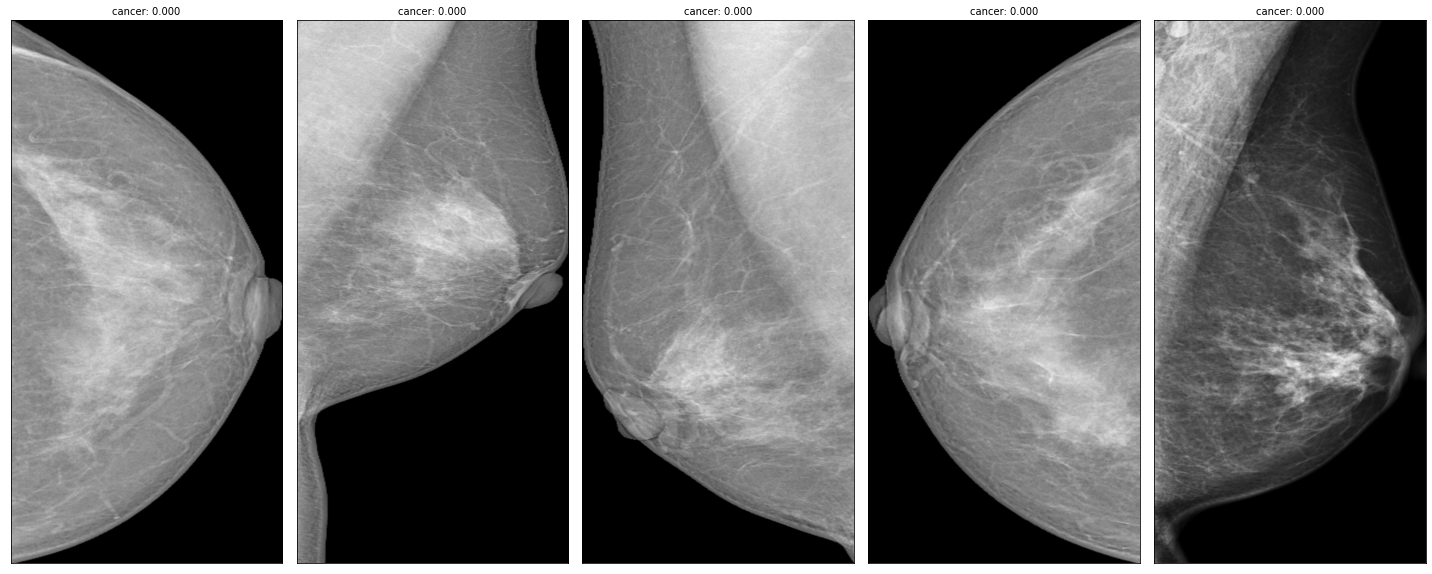

In [16]:
fold = 0
fold_df = df.groupby('cancer').head(16)
paths  = fold_df.image_path.tolist()
labels = fold_df[CFG.target_col].values
ds = build_dataset(paths, labels, cache=False, batch_size=32,
                   repeat=True, shuffle=True, augment=False)
ds = ds.unbatch().batch(20)
batch = next(iter(ds))
display_batch(batch, 5);

# GradCAM Utils

In [17]:
import matplotlib.cm as cm, cv2
from tensorflow import keras

def gen_gradcam_heatmap(img, model, last_conv='top_conv', pred_index=0):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        features, preds = grad_model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, features)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    features = features[0]
    heatmap = features @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds[0]


def get_gradcam(img, model):

    heatmap, pred = gen_gradcam_heatmap(img, model, last_conv='top_conv', pred_index=0)
    heatmap = cv2.resize(heatmap, dsize=(img.shape[2], img.shape[1]))
        
    return heatmap, pred

def gray2rgb(img, gradcam, alpha=0.55, cmap='inferno'):
    """Convert grayscale heatmap to jet gradcam"""
    # Use jet colormap to colorize heatmap
    cmap = cm.get_cmap(cmap)

    # Use RGB values of the colormap
    colors  = cmap(np.arange(256))[:, :3]
    heatmap = colors[gradcam]

    # Superimpose the heatmap on original image
    sup_img = heatmap * alpha + (img/255.0)
    sup_img = tf.keras.preprocessing.image.array_to_img(sup_img) # avoid saturated colors
    return np.asarray(sup_img)

# BBox Utils

In [18]:
import cv2
from bbox.utils import draw_bboxes
import matplotlib.cm as cm

def gradcam2bbox(gradcam, thr=0.6):
    # Binarize the image
    mask = (gradcam>thr).astype('uint8')

    # Make contours around the binarized image, keep only the largest contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)

    # Find ROI from largest contour
    ys = contour.squeeze()[:, 0]
    xs = contour.squeeze()[:, 1]
    
    y1 = np.min(xs); y2 = np.max(xs);
    x1 = np.min(ys); x2 = np.max(ys);
    
    return [x1, y1, x2, y2]

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]
font_param = {"fontname":"Times New Roman","fontweight":"bold", "fontsize":16}

# **Wandb** Logger
Log:
* Image
* Mask
* BBox

In [19]:
class_labels = {
    1: "cancer",
}

def wandb_init(fold):
    config = {k:v for k,v in dict(vars(CFG)).items() if '__' not in k}
    config.update({"fold":int(fold)})
    run    = wandb.init(project="rsna-bcd-gradcam2bbox",
               name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
               config=config,
               anonymous=anonymous,
                    )
    return run

def log_wandb(fold, data):
    # Create wandb table with gradcam, bbox, mask
    wandb_data = []
    for idx, row in enumerate(tqdm(data, desc='wandb ')):
        tab = row[0]
        img = row[1]
        gradcam = gray2rgb(img, row[2])
        mask = (row[2]>(CFG.mask_thr*255.0)).astype('uint8')
        bbox = tab[-2][0]
        
        # Add row to table
        wandb_data+=[[*tab,
                wandb.Image(img), 
                wandb.Image(gradcam),
                wandb.Image(img, masks={
                    "ground_truth": {"mask_data": mask,
                                     "class_labels": class_labels,}
                }),
                wandb.Image(img, boxes={"ground_truth": {"box_data": [{"position": {"minX": int(bbox[0]),
                                                                                    "maxX": int(bbox[2]),
                                                                                    "minY": int(bbox[1]),
                                                                                    "maxY": int(bbox[3])},
                                                                       "class_id" : 1,
                                                                       "box_caption": "cancer",
                                                                       "domain" : "pixel",}],
                                                         "class_labels": class_labels,},
                                       })
               ]]
        
    # Create Table
    wandb_table = wandb.Table(data=wandb_data,
                              columns=[*cols, 'image', 'gradcam','mask_img','bbox_img'])
    
    # Log data to wandb
    wandb.log({'viz_table':wandb_table,})

# Generate BBox from GradCAM

In [20]:
oof_pred = []; oof_tar = []; oof_val = []; oof_ids = []; oof_folds = []
preds = np.zeros((test_df.shape[0],1))

for fold in np.arange(CFG.folds):
    
    # Ignore not selected folds
    if fold not in CFG.selected_folds:
        continue
        
    # Init wandb
    if CFG.wandb:
        run = wandb_init(fold)

    # Train and valid dataframe
    valid_df = df.query("fold==@fold")
    
    # Get image_paths and labels
    valid_paths = valid_df.image_path.values; valid_labels = valid_df[CFG.target_col].values.astype(np.float32)
    
    # Min samples in debug mode
    min_samples = CFG.batch_size*REPLICAS*2
    
    # For debug model run on small portion
    if CFG.debug:
        valid_paths = valid_paths[:min_samples]; valid_labels = valid_labels[:min_samples]
    
    # Sample count
    num_valid = len(valid_paths)
    num_valid_pos = (valid_labels==1).sum()
    
    # Show message
    print('#'*40); print('#### FOLD: ',fold)
    print('#### NUM_SAMPLES: {:,} | NUM_CANCER: {:,}'.format(num_valid, num_valid_pos))
    print('#'*40)
    
    # Build model
    print('Loading model...')
    K.clear_session()
    with strategy.scope():
        model = tf.keras.models.load_model(f'{CKPT_PATH}/fold-%i.h5'%fold,
                                          compile=False)
    
    # Celect top and worst 10 cases for each class
    gradcam_df  = valid_df.query("cancer==1").reset_index(drop=True)
    gradcam_ds  = build_dataset(gradcam_df.image_path.values, labels=None, cache=False, batch_size=1,
                   repeat=False, shuffle=False, augment=False)
    
    # Columns
    noimg_cols  = ['image_id','patient_id','cancer']
    cols = noimg_cols + ['bbox','pred']
    
    # Create wandb table for upload
    data = []
    for idx, img in enumerate(tqdm(gradcam_ds, total=len(gradcam_df), desc='gradcam ')):
        gradcam, pred = get_gradcam(img, model)
        bbox = [gradcam2bbox(gradcam, thr=CFG.mask_thr)]
        tab = gradcam_df.loc[idx, noimg_cols].tolist()+[bbox, pred[0].numpy()]
        img = img.numpy()[0]
        img = (img*255.0).astype('uint8')
        gradcam = (gradcam*255.0).astype('uint8')
        if pred>=CFG.conf_thr:
            data+=[[tab, img, gradcam]]
    
    # Save bbox data for each fold
    bbox_df = pd.DataFrame([x[0] for x in data], columns=cols)
    bbox_df.to_csv(f'bbox{fold}.csv',index=False)
            
    # Log bbox, mask, gradcam on wandb & plot
    if CFG.wandb:
        log_wandb(fold, data) # log
        wandb.run.finish() # finish the run
        display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard
        
    # Clean unless last fold (last fold for local plotting)
    if fold!=CFG.selected_folds[-1]:
        del data; gc.collect()
        
    print();

wandb: Currently logged in as: awsaf49. Use `wandb login --relogin` to force relogin


########################################
#### FOLD:  0
#### NUM_SAMPLES: 10,840 | NUM_CANCER: 248
########################################
Loading model...


gradcam :   0%|          | 0/248 [00:00<?, ?it/s]

wandb :   0%|          | 0/53 [00:00<?, ?it/s]

########################################
#### FOLD:  1
#### NUM_SAMPLES: 11,005 | NUM_CANCER: 238
########################################
Loading model...


gradcam :   0%|          | 0/238 [00:00<?, ?it/s]

wandb :   0%|          | 0/54 [00:00<?, ?it/s]

########################################
#### FOLD:  2
#### NUM_SAMPLES: 10,952 | NUM_CANCER: 205
########################################
Loading model...


gradcam :   0%|          | 0/205 [00:00<?, ?it/s]

wandb :   0%|          | 0/61 [00:00<?, ?it/s]

########################################
#### FOLD:  3
#### NUM_SAMPLES: 10,899 | NUM_CANCER: 206
########################################
Loading model...


gradcam :   0%|          | 0/206 [00:00<?, ?it/s]

wandb :   0%|          | 0/70 [00:00<?, ?it/s]

########################################
#### FOLD:  4
#### NUM_SAMPLES: 11,010 | NUM_CANCER: 261
########################################
Loading model...


gradcam :   0%|          | 0/261 [00:00<?, ?it/s]

wandb :   0%|          | 0/92 [00:00<?, ?it/s]

# Visualize Gradcam & BBox

####################
ImageID: 1096308702
PatientID: 11341
View: 11341
Laterality: 1096308702
Pred: 0.619
####################


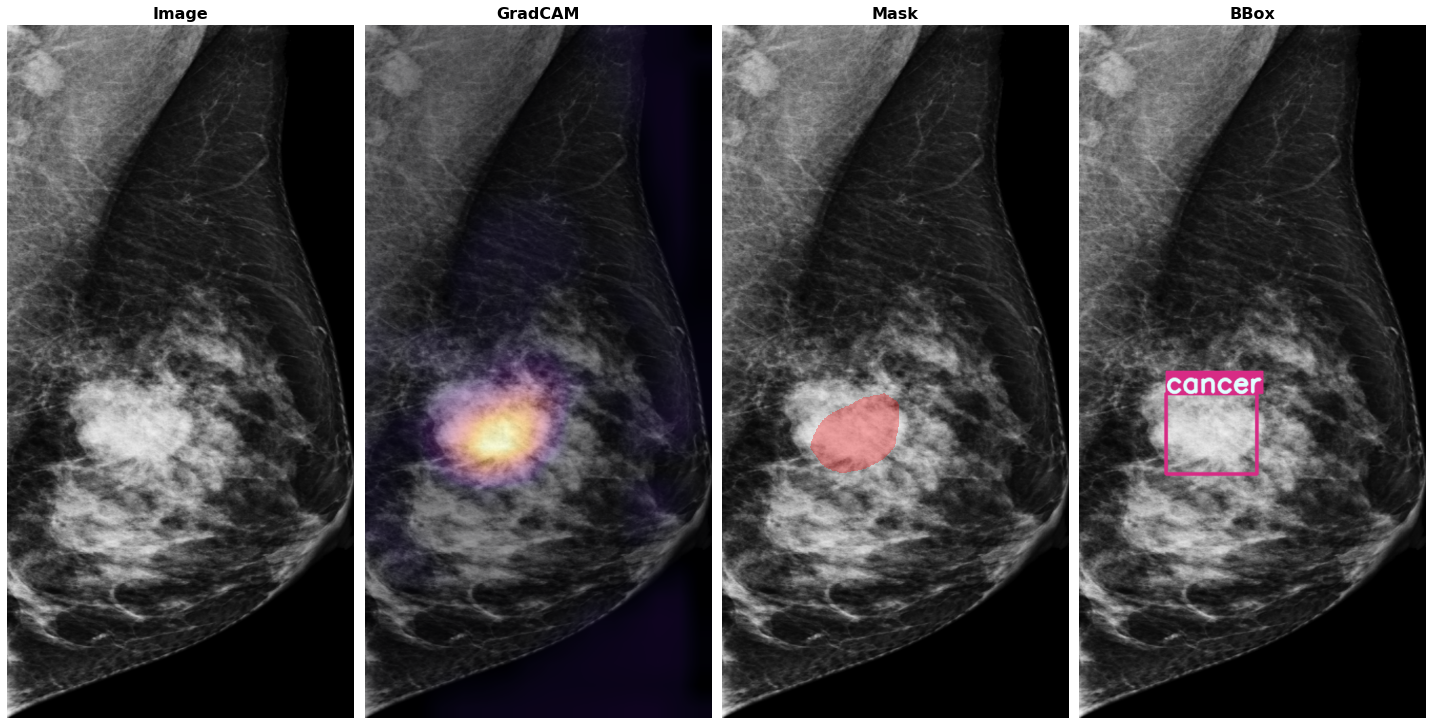


####################
ImageID: 982883275
PatientID: 12392
View: 12392
Laterality: 982883275
Pred: 0.894
####################


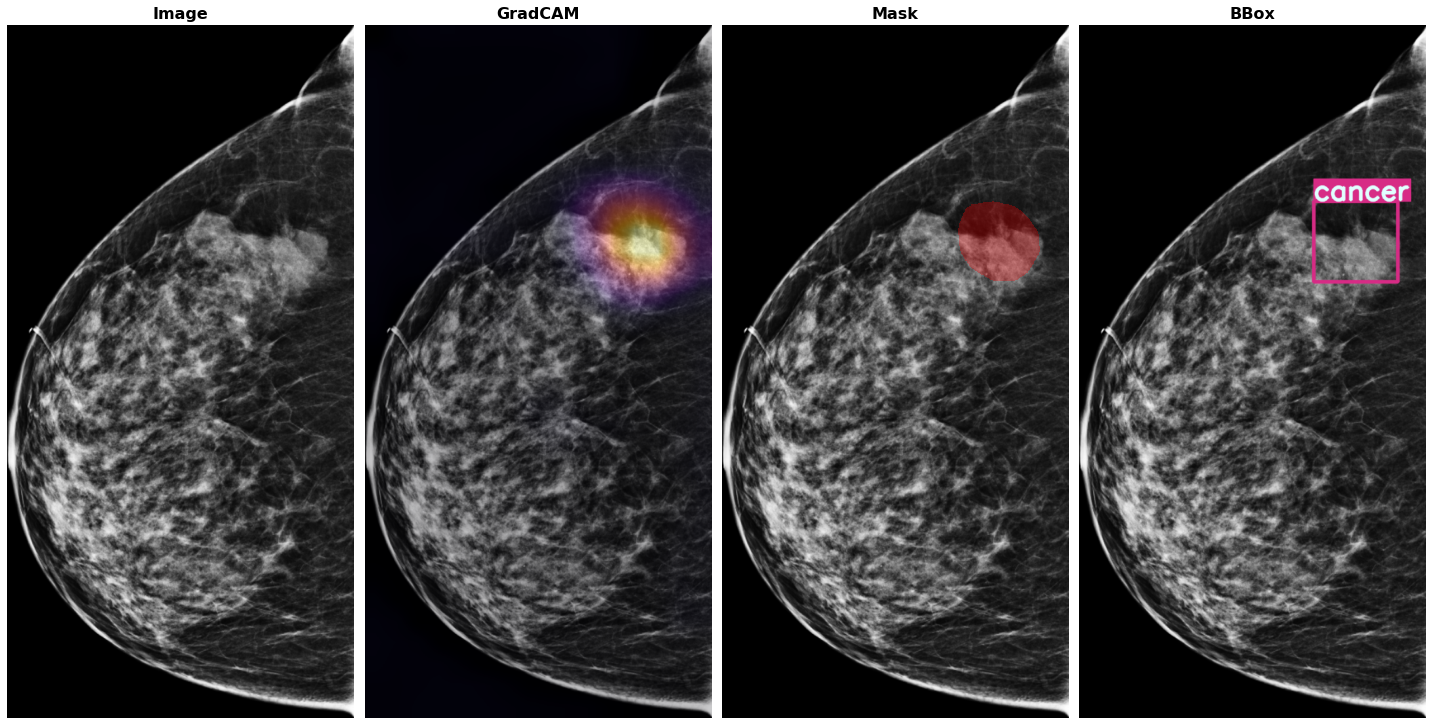


####################
ImageID: 1446339465
PatientID: 12485
View: 12485
Laterality: 1446339465
Pred: 0.582
####################


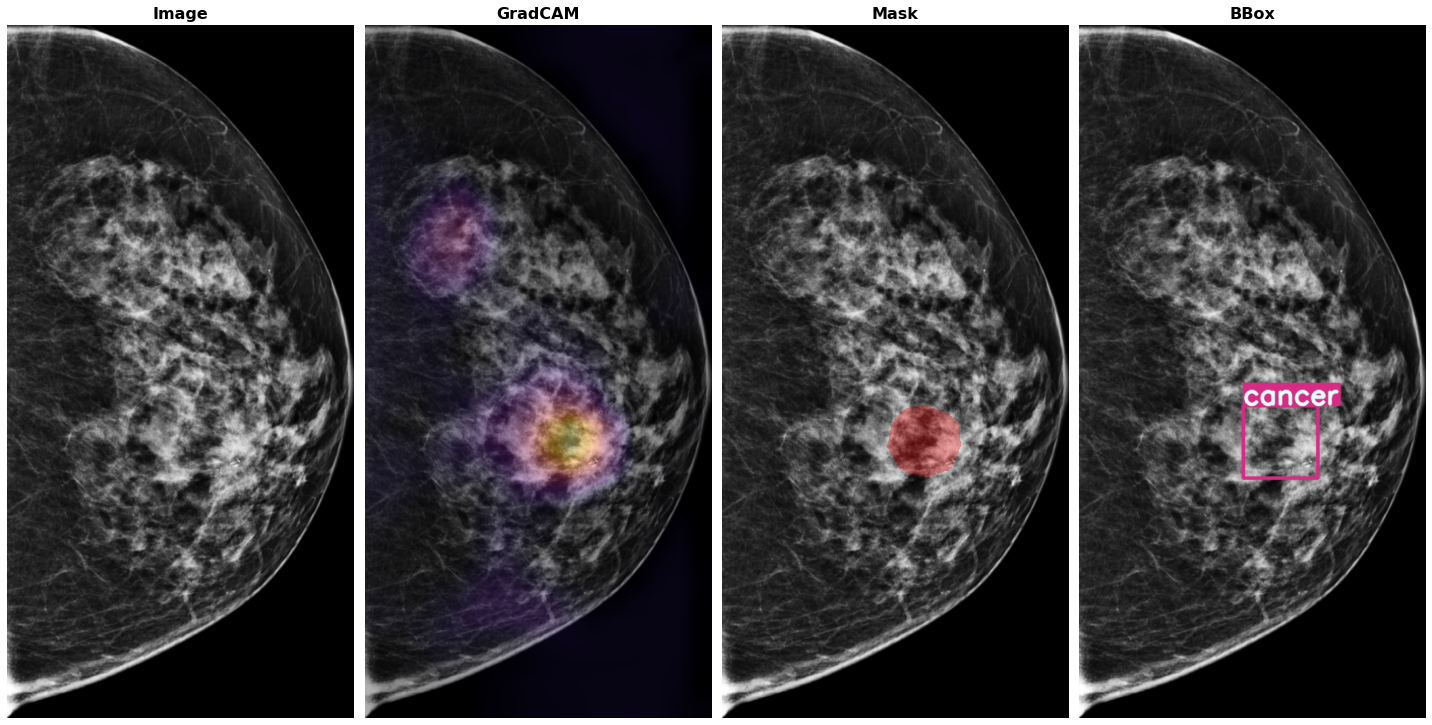


####################
ImageID: 1563019139
PatientID: 12485
View: 12485
Laterality: 1563019139
Pred: 0.705
####################


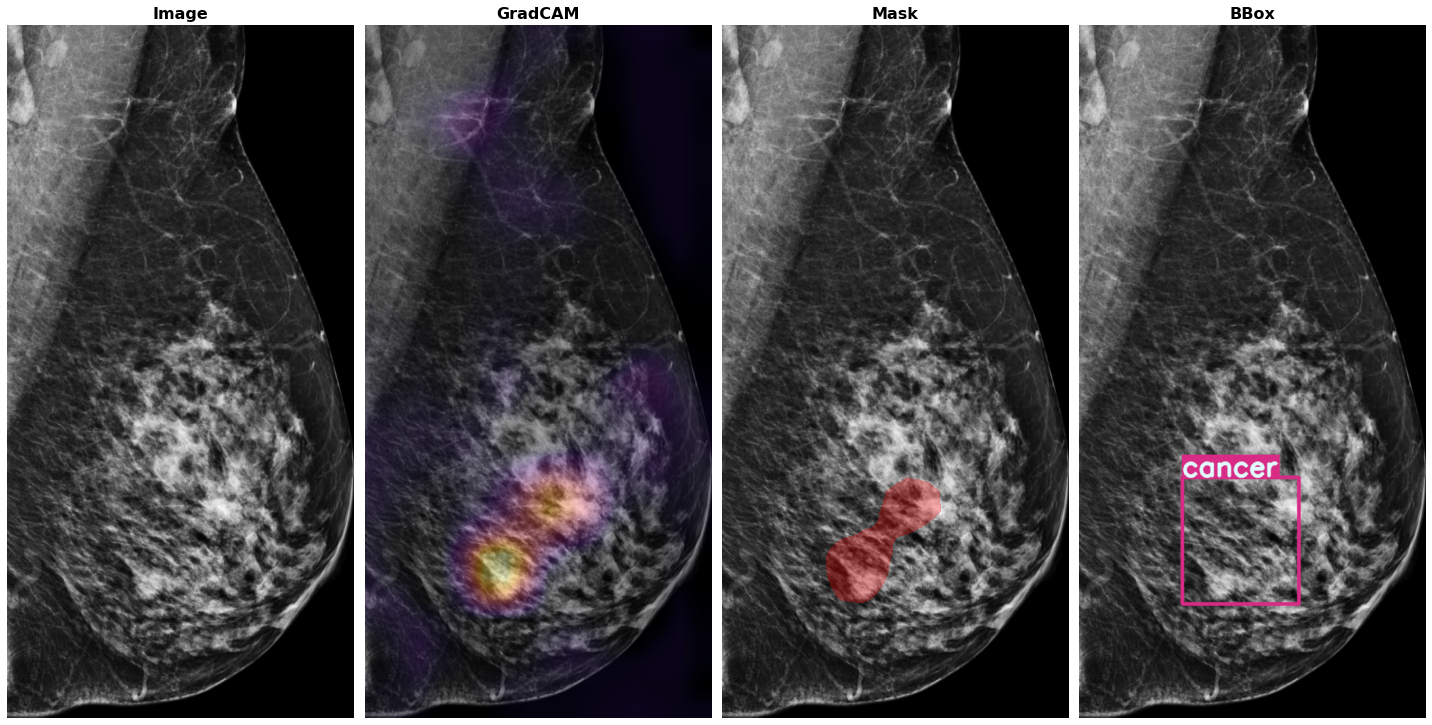


####################
ImageID: 551129512
PatientID: 12988
View: 12988
Laterality: 551129512
Pred: 0.789
####################


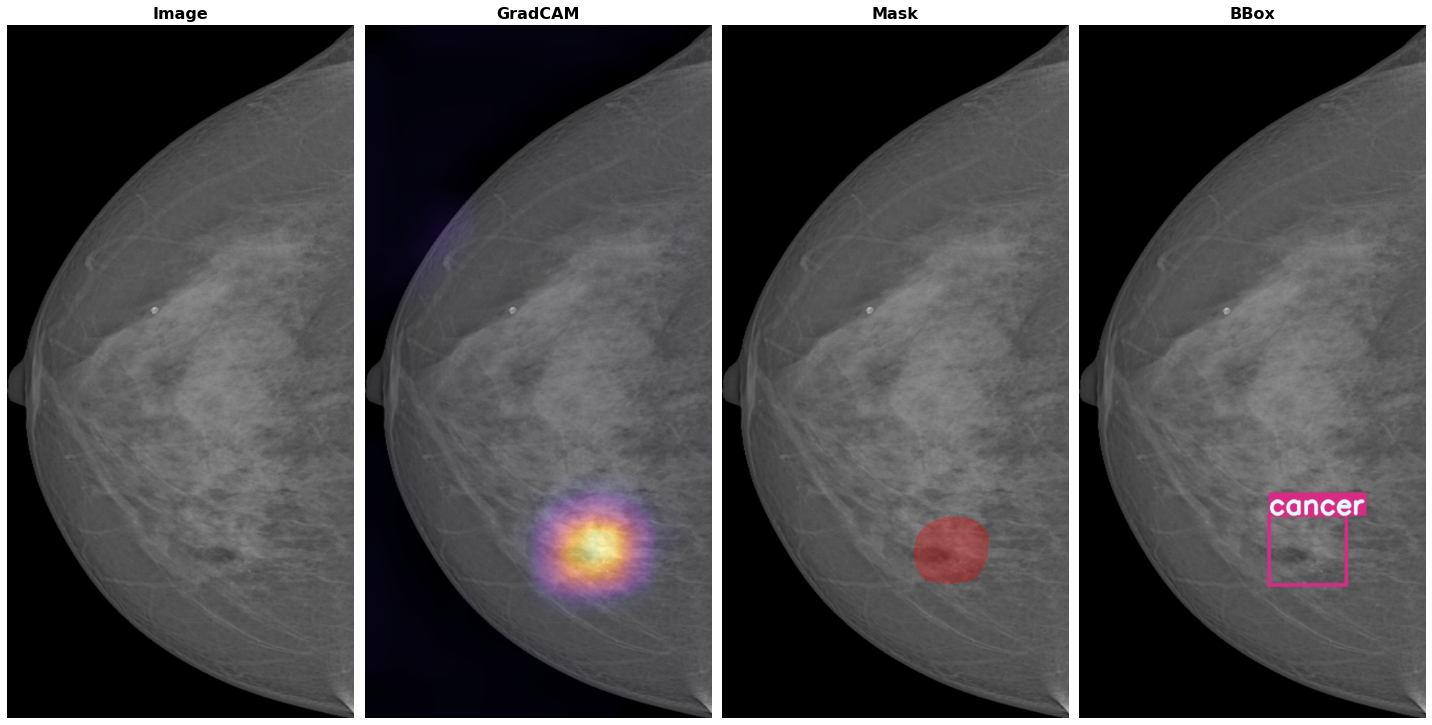

In [21]:
for idx in range(5):
    row = data[idx]
    img = row[1].copy()
    gradcam = gray2rgb(img, row[2])
    mask = (row[2]>(CFG.mask_thr*255.0)).astype('uint8')
    
    tab = row[0]
    iid = tab[0]; pid = tab[1]; view = tab[-4]; lat = tab[-5]; pred=tab[-1]
    bboxes = tab[-2]  # voc pascal style
    
    plt.figure(figsize=(20,10))
    print("#"*20)
    print(f"ImageID: {iid}\nPatientID: {pid}\nView: {view}\nLaterality: {lat}")
    print(f"Pred: {pred:0.3f}")
    print("#"*20)

    # Plot image
    plt.subplot(141)
    plt.imshow(img)
    plt.title("Image", **font_param); plt.axis('off')

    # Plot GradCAM
    plt.subplot(142)
    plt.imshow(gradcam)
    plt.title("GradCAM", **font_param); plt.axis('off')

    # Plot Mask
    plt.subplot(143)
    plt.imshow(img)
    plt.imshow(np.ma.masked_where(mask==0, mask), alpha=0.3, cmap='autumn')
    plt.title("Mask", **font_param); plt.axis('off')

    # Plot BBox
    plt.subplot(144)
    labels = [0]*1
    names = ['cancer']*1
    plt.imshow(draw_bboxes(img = img,
                               bboxes = bboxes, 
                               classes = names,
                               class_ids = labels,
                               class_name = True, 
                               colors = colors, 
                               bbox_format = 'voc',
                               line_thickness = 4))
    plt.title("BBox", **font_param); plt.axis('off')

    plt.tight_layout()
    plt.show()
    print()

# Store BBox

In [22]:
bbox_df = pd.concat([pd.read_csv(f'bbox{fold}.csv') for fold in CFG.selected_folds], axis=0, ignore_index=True)
print(f'BBox Size: {len(bbox_df)}')
bbox_df.head()

BBox Size: 330


image_id  patient_id  cancer                    bbox      pred
0    91797551       12195       1  [[299, 527, 396, 628]]  0.457484
1   100147863       12195       1   [[52, 566, 214, 724]]  0.718408
2  1494928875       16668       1   [[91, 308, 207, 413]]  0.985006
3   583119542       19486       1  [[208, 610, 317, 721]]  0.902857
4   886797800       19486       1  [[237, 602, 355, 706]]  0.890953

# Remove Files

In [23]:
!rm -r /kaggle/working/wandb